# Figure 6. Reduction in Wolbachia RR enabled by prior suppression with seasonality
Author: Katie Tiley (katherine.tiley@lshtm.ac.uk) <br>
Date: 05 Dec 22 <br>
<br>
Note: in the code RIDL refers to 1gSLT, and IIT refers to Male Wolbachia release

In [2]:
from scipy.integrate import odeint
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
from scipy import integrate as sp
import seaborn as sns
from tabulate import tabulate
import pandas as pd
import statsmodels.api as sm
import json
from decimal import Decimal as dec
import time
import os

In [3]:
filepath = os.path.abspath(os.getcwd())

### 1. Set up model
Parameters:

In [2]:
# MOSQUITO
alphaO = 0.5  # rate that eggs hatch into larvae
alphaL = 0.18  # rate that larvae pupate
alphaP = 1  # rate that pupae eclose
phi = 500*(1/14)    # number eggs laid per mosquito per day
muO = 0.01    # daily death rate of eggs
muL = 0.1*alphaL    # daily death rate of larvae
muP = 0.1*alphaP     # pupae death rate
muM = 1/14     # adult mosquito death rate
muF = 1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA = 1   # determines the density at which mortality remains proportionate
BB = 0.5   # determines the 'abruptness' of density-dependence

# WOLBACHIA
fCI = 0.012   # prop of cytoplasmic incompatibility that fails 'sigma'
MT = 0    # prop of wolbachia females that don't successfully maternally transfer 'omega'
c = 0.5    # mating competitiveness of released wolbachia males
cv = 1    # coverage of adulticide
e = 1.2    # relative mortality of wolbachia adults compared to wild adults
RR = 1    # release ratio of wolbachia eggs to wild type eggs
RRsupp = 1    # release ratio of wolbachia eggs to wild type eggs for suppression techniques

Initial conditions:
(equilibrium values previously defined in Supp)

In [3]:
O0 = 15947.608023052446
OW0 = 0
rOW0 = 0
OS0 = 0
L0 = 40271.71074193975
LW0 = 0
rLW0 = 0
LS0 = 0
P0 = 32.67541200187585
PW0 = 0
rPW0 = 0
PS0 = 0
M0 = 228.72754035145144
MW0 = 0
MS0 = 0
F0 = 228.72754035145144
FW0 = 0

Seasonal precipitation function:

In [15]:
SA = 2.09    # brings seasonal population average to match non-seasonal model so functions still apply

with open("Rio.json", 'r') as f: # import precipitation data
    score = json.load(f)  

def K(t):
    return (score[round(t)])*SA

Wolbachia release function:

In [16]:
start_wol = 200

def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
    for i in range(0,releasenumber,1):
        if round(t) == start_wol + (frequency*i):
            return 0 #O0
    else:
        return 0

Suppression functions:

In [17]:
# IIT

def IIT(t, releasenumber=1, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

In [18]:
# SIT / RIDL

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

In [19]:
# Environmental management

start_em = 193
stop_em = 200
em_eff = 1 #0.526

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [20]:
# Larvicides (e.g. guppies)

start_lv = 193
stop_lv = 200
lv_eff = 1 #5.95

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [21]:
# Adulticide

h = start_wol

def ad(t):    
    ad_eff = 0 #4.9 #0.455
    if round(t) < h:
        return 0
    elif round(t) > h+0.01:
        return 0
    else:
        return ad_eff

Model:

In [22]:
def deriv(y, t, fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, K, IIT, SIT, em, lv, ad, cv, switch):
    
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = y
    
    #MOSQUITOES
    
    allfemales = 1+F+FW
    allmales = 1+M+MW+(MS*c)
    
    F_nothing = F + FW*MT 
    M_nothing = M + MW*fCI 
    
    F_wol = FW*(1-MT)
    
    #Eggs
    dOdt = em(t) * phi * F_nothing * M_nothing/allmales - alphaO*O - lv(t)*muO*O # eggs laid * females no-wol * (males no_wol / all males) (aka prop no-wol males)
    dOWdt = em(t) * phi * F_wol * (M+MW)/allmales - alphaO*OW - lv(t)*muO*OW 
    drOWdt = pulseN(t)*RR - alphaO*rOW - muO*rOW
    dOSdt = phi * allfemales * (MS*c)/allmales - alphaO*OS - muO*OS
    
    #Larvae
    dLdt =  alphaO*O - alphaL*L - lv(t)*muL*L
    dLWdt = alphaO*OW - alphaL*LW - lv(t)*muL*LW
    drLWdt = alphaO*rOW - alphaL*rLW - muL*rLW
    dLSdt = switch*alphaO*OS - alphaL*LS - muL*LS
    
    #Pupae 
    dPdt =  alphaL*(L/(1+((AA*K(t)*(L+LW+LS))**BB))) - alphaP*P - lv(t)*muP*P 
    dPWdt = alphaL*(LW/(1+((AA*K(t)*(L+LW+LS))**BB))) - alphaP*PW - lv(t)*muP*PW
    drPWdt = alphaL*(rLW/(1+((AA*(rLW))**BB))) - alphaP*rPW - muP*rPW 
    dPSdt = alphaL*(LS/(1+((AA*K(t)*(L+LW+LS))**BB))) - alphaP*PS - muP*PS
        
    #Adult
    dMdt =  .5*alphaP*P - muM*M - ad(t)*M*cv
    dMWdt = IIT(t)*RRsupp + .5*alphaP*(PW+rPW) - muM*e*MW - ad(t)*MW*cv
    dMSdt = SIT(t)*RRsupp + .5*alphaP*PS - muM*e*MS
    
    dFdt =  .5*alphaP*P - muF*F - ad(t)*F*cv
    dFWdt = .5*alphaP*(PW+rPW) - muF*e*FW - ad(t)*FW*cv

    return dOdt, dOWdt, drOWdt, dOSdt, dLdt, dLWdt, drLWdt, dLSdt, dPdt, dPWdt, drPWdt, dPSdt, dMdt, dMWdt, dMSdt, dFdt, dFWdt

Model prerequisites:

In [23]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # initial condition vector

Run model:

In [24]:
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, K, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

Visual check all suppression functions are off and seasonality is effective: (should see cyclic population)

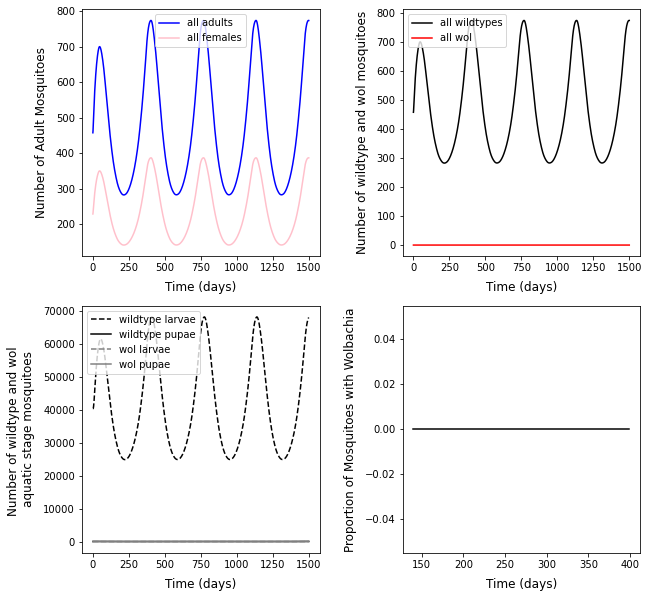

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])

ax1.plot(t, F+FW+M+MW, 'blue', label='all adults')
ax1.plot(t, F+FW, 'pink', label='all females')
ax1.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax1.set_ylabel("Number of Adult Mosquitoes",fontsize=12, labelpad=8)
ax1.legend()

ax2.plot(t, M+F, 'black', label='all wildtypes')
ax2.plot(t, MW+FW, 'red', label='all wol')
ax2.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax2.set_ylabel("Number of wildtype and wol mosquitoes",fontsize=12, labelpad=8)
ax2.legend()

ax3.plot(t, L, 'black', linestyle='dashed', label='wildtype larvae')
ax3.plot(t, P, 'black', label='wildtype pupae')
ax3.plot(t, LW, 'grey', linestyle='dashed', label='wol larvae')
ax3.plot(t, PW, 'grey', label='wol pupae')
ax3.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax3.set_ylabel("Number of wildtype and wol \naquatic stage mosquitoes",fontsize=12, labelpad=8)
ax3.legend()

ax4.plot(t[140:400], (MW[140:400]+FW[140:400])/(MW[140:400]+FW[140:400]+M[140:400]+F[140:400]), 'black')
plt.xticks([150,200,250,300,350,400])
ax4.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia", fontsize=12, labelpad=8)


plt.subplots_adjust(wspace=.35)

#plt.savefig('wolAedesDemo-KT', dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', format=None, transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

In [15]:
# baseline seasonality population dynamics

O_base = O
L_base = L
P_base = P
M_base = M
F_base = F

Convert raw eggRR values into adultRR values:

In [88]:
RR_df = pd.read_csv(f'{filepath}/adultRR_eggRR_df.csv')

def convert_RR(RR):
    return  list(RR_df.loc[RR_df['eggRR'] == RR]['adultRR'])[0]

In [89]:
RR_df

,adultRR,eggRR
0,0.0025,0.0005
1,0.0050,0.0010
2,0.0075,0.0015
3,0.0100,0.0020
4,0.0125,0.0025
...,...,...
195,0.4900,2.3630
196,0.4925,2.3870
197,0.4950,2.4115
198,0.4975,2.4360


### 2.a. Data collection: minimum Wolbachia RR with each suppression for fixation within 6 months
### No suppression:

In [90]:
start_time = time.time()




RR_vec = list(RR_df.iloc[:,1])
nosupp_RR = [] #capture results here
start_wol = 0
eggRR = 0
x = 0


while start_wol < 722:

    
    start_wol = start_wol+7
    x = x+1 # index for storing results
    zoo = [] # shell capturing within-loop results
    loop_start_time = time.time()
    
    def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
        for i in range(0,releasenumber,1):
            if round(t) == start_wol + (frequency*i):
                return O0
        else:
            return 0
    
    
    if eggRR == 0: # search whole RR vec
        a = 0
        b = 199
    else: # search only within range of last RR
        idx = list(RR_df.index[RR_df['eggRR'] == eggRR])
        
        if idx[0]-15 < 1: #if lower boundary crosses 0 set as 0
            a = 0
        else:
            a = idx[0]-15
        
        if idx[0]+15 > 199: #if upper boundary crosses max set as max
            b = 199
        else:
            b = idx[0]+15
        
    
    for i in RR_vec[a:b]:
        
        RR = i
                
        # run the model
        t = np.linspace(0, 1500, 1501) # grid of time points (in days)
        y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # initial condition vector
        ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, K, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

        # get output
        total = MW+FW+M+F
        prop = (MW+FW)/(MW+FW+M+F)
    
        # find fixation points
        fix = np.argwhere(prop > 0.95)
        if sum(fix) > 0:
            min_fix = min(fix)-start_wol
            min_fix = min_fix.tolist()
        else:
            min_fix = 0 #occurs if no fixation
        
        zoo.append(min_fix) #store fixation points
        
        
    # flatten list
    flat_list = []
    for sublist in zoo:
        if type(sublist) == list:
            for item in sublist:
                flat_list.append(item)
        else:
            flat_list.append(sublist)
    
    
    # only keep fix within 6 months
    sixm_list2 = [] 
    for i in flat_list:
        if (i >= 182.5) == True: #within 6 months
            i = 0
        sixm_list2.append(i)
    
    
    # convert eggRR to adultRR and store result outside of loop
    if sum(sixm_list2) > 0: 
        ind = (sixm_list2.index(max(sixm_list2)))
        eggRR = RR_vec[ind+a]
        adultRR = convert_RR(eggRR)
        nosupp_RR.append(adultRR)
    else:
        eggRR = 0
        nosupp_RR.append('NaN')

    print("Loop ",x,", start wol:", start_wol)
    current_time = time.time()
    elapsed_time = current_time - loop_start_time
    print('processing time:',round(elapsed_time/60,2),'minutes')
        

print("Kernel complete")
current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

Loop  1 , start wol: 7
processing time: 8.23 minutes
Loop  2 , start wol: 14
processing time: 1.23 minutes
Loop  3 , start wol: 21
processing time: 1.23 minutes
Loop  4 , start wol: 28
processing time: 4.91 minutes
Loop  5 , start wol: 35
processing time: 1.23 minutes
Loop  6 , start wol: 42
processing time: 1.23 minutes
Loop  7 , start wol: 49
processing time: 1.23 minutes
Loop  8 , start wol: 56
processing time: 1.24 minutes
Loop  9 , start wol: 63
processing time: 1.24 minutes
Loop  10 , start wol: 70
processing time: 1.25 minutes
Loop  11 , start wol: 77
processing time: 1.24 minutes
Loop  12 , start wol: 84
processing time: 1.24 minutes
Loop  13 , start wol: 91
processing time: 1.24 minutes
Loop  14 , start wol: 98
processing time: 1.24 minutes
Loop  15 , start wol: 105
processing time: 1.24 minutes
Loop  16 , start wol: 112
processing time: 1.24 minutes
Loop  17 , start wol: 119
processing time: 1.24 minutes
Loop  18 , start wol: 126
processing time: 1.24 minutes
Loop  19 , start

In [91]:
nosupp_RR

[0.2075,
 0.21,
 0.21,
 0.2075,
 0.2,
 0.1925,
 0.185,
 0.175,
 0.165,
 0.155,
 0.145,
 0.1375,
 0.13,
 0.1225,
 0.115,
 0.11,
 0.1025,
 0.1,
 0.095,
 0.0925,
 0.0875,
 0.0875,
 0.085,
 0.0825,
 0.0825,
 0.0825,
 0.0825,
 0.0825,
 0.0825,
 0.0825,
 0.085,
 0.0875,
 0.09,
 0.0925,
 0.095,
 0.1,
 0.105,
 0.11,
 0.1175,
 0.1225,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.1825,
 0.195,
 0.205,
 0.215,
 0.225,
 0.2325,
 0.2375,
 0.2375,
 0.235,
 0.23,
 0.2225,
 0.215,
 0.205,
 0.1925,
 0.1825,
 0.17,
 0.16,
 0.15,
 0.14,
 0.1325,
 0.125,
 0.1175,
 0.11,
 0.105,
 0.1,
 0.095,
 0.0925,
 0.09,
 0.0875,
 0.085,
 0.0825,
 0.0825,
 0.0825,
 0.0825,
 0.0825,
 0.0825,
 0.0825,
 0.085,
 0.0875,
 0.09,
 0.0925,
 0.095,
 0.1,
 0.105,
 0.11,
 0.115,
 0.1225,
 0.13,
 0.1375,
 0.1475,
 0.1575,
 0.17,
 0.18,
 0.1925,
 0.2025,
 0.215,
 0.225,
 0.23,
 0.235]

In [92]:
len(nosupp_RR) # check 104 timepoints, two years sampled weekly

104

In [93]:
data = {'nosupp_RR': nosupp_RR}

nosupp_RR_df = pd.DataFrame(data)
nosupp_RR_df.to_csv('nosupp_RR.csv')

### IIT

In [94]:
IIT_df = pd.read_csv(f'{filepath}/IIT_df.csv')
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 60, 'RRsupp value'])
RRsupp = RRsupp[0]

In [95]:
start_time = time.time()




RR_vec = list(RR_df.iloc[:,1])
IIT_RR = [] #capture results here
start_wol = 0
eggRR = 0
x = -1


while start_wol < 722:

    
    start_wol = start_wol+7
    x = x+1 # index for storing results
    zoo = [] # shell capturing within-loop results
    
    
    def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
        for i in range(0,releasenumber,1):
            if round(t) == start_wol + (frequency*i):
                return O0
        else:
            return 0
    
    def IIT(t, releasenumber=5, frequency=7, end=start_wol):
        for i in range(0,releasenumber,1):
            if round(t) == (end-frequency) - (frequency*i):
                return M0+F0
        else:
            return 0
    
    if eggRR == 0: # search whole RR vec
        a = 0
        b = 199
    else: # search only within range of last RR
        idx = list(RR_df.index[RR_df['eggRR'] == eggRR])
        
        if idx[0]-15 < 0: #if lower boundary crosses 0 set as 0
            a = 0
        else:
            a = idx[0]-15
        
        if idx[0]+15 > 199: #if upper boundary crosses max set as max
            b = 199
        else:
            b = idx[0]+15
        
    
    for i in RR_vec[a:b]:
        
        RR = i
        
        # run the model
        t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
        y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
        ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, K, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

        # get output
        total = MW+FW+M+F
        prop = (MW+FW)/(MW+FW+M+F)
    
        # find fixation points
        fix = np.argwhere(prop > 0.95)
        if sum(fix) > 0:
            min_fix = min(fix)-start_wol
            min_fix = min_fix.tolist()
        else:
            min_fix = 0 #occurs if no fixation
        
        zoo.append(min_fix) #store fixation points
        
    
    # flatten list
    flat_list = []
    for sublist in zoo:
        if type(sublist) == list:
            for item in sublist:
                flat_list.append(item)
        else:
            flat_list.append(sublist)
    
    
    # only keep fix within 6 months
    sixm_list2 = [] 
    for i in flat_list:
        if (i >= 182.5) == True: #within 6 months
            i = 0
        sixm_list2.append(i)
    
    
    # convert eggRR to adultRR and store result outside of loop
    if sum(sixm_list2) > 0: 
        ind = (sixm_list2.index(max(sixm_list2)))
        eggRR = RR_vec[ind+a]
        adultRR = convert_RR(eggRR)
        IIT_RR.append(adultRR)
    else:
        eggRR = 0
        IIT_RR.append('NaN')
        
        
    print("Loop ",x,", start wol:", start_wol)
    current_time = time.time()
    elapsed_time = current_time - start_time
    print('processing time:',round(elapsed_time/60,2),'minutes')
    
    
    
print("Kernel complete")   
current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

Loop  0 , start wol: 7
processing time: 8.56 minutes
Loop  1 , start wol: 14
processing time: 9.85 minutes
Loop  2 , start wol: 21
processing time: 11.15 minutes
Loop  3 , start wol: 28
processing time: 12.44 minutes
Loop  4 , start wol: 35
processing time: 13.74 minutes
Loop  5 , start wol: 42
processing time: 15.02 minutes
Loop  6 , start wol: 49
processing time: 16.32 minutes
Loop  7 , start wol: 56
processing time: 17.62 minutes
Loop  8 , start wol: 63
processing time: 18.91 minutes
Loop  9 , start wol: 70
processing time: 20.2 minutes
Loop  10 , start wol: 77
processing time: 21.49 minutes
Loop  11 , start wol: 84
processing time: 22.79 minutes
Loop  12 , start wol: 91
processing time: 24.08 minutes
Loop  13 , start wol: 98
processing time: 25.38 minutes
Loop  14 , start wol: 105
processing time: 26.68 minutes
Loop  15 , start wol: 112
processing time: 27.93 minutes
Loop  16 , start wol: 119
processing time: 29.08 minutes
Loop  17 , start wol: 126
processing time: 30.2 minutes
Loo

In [96]:
IIT_RR

[0.175,
 0.1375,
 0.11,
 0.0875,
 0.0725,
 0.0675,
 0.0675,
 0.065,
 0.0625,
 0.0575,
 0.055,
 0.05,
 0.045,
 0.0425,
 0.0375,
 0.0325,
 0.03,
 0.0275,
 0.0249999999999999,
 0.02,
 0.015,
 0.0125,
 0.01,
 0.01,
 0.0075,
 0.0075,
 0.0075,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.0075,
 0.0075,
 0.0075,
 0.01,
 0.01,
 0.0125,
 0.0174999999999999,
 0.02,
 0.0249999999999999,
 0.03,
 0.0325,
 0.0375,
 0.0425,
 0.0475,
 0.055,
 0.0625,
 0.07,
 0.075,
 0.08,
 0.0825,
 0.085,
 0.085,
 0.0825,
 0.08,
 0.075,
 0.07,
 0.065,
 0.06,
 0.055,
 0.05,
 0.045,
 0.04,
 0.035,
 0.0325,
 0.0275,
 0.0249999999999999,
 0.02,
 0.0174999999999999,
 0.015,
 0.0125,
 0.01,
 0.0075,
 0.0075,
 0.0075,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.0075,
 0.0075,
 0.01,
 0.01,
 0.0125,
 0.015,
 0.02,
 0.0249999999999999,
 0.0275,
 0.0325,
 0.0375,
 0.0425,
 0.0475,
 0.055,
 0.06,
 0.0675]

In [97]:
len(IIT_RR) # check 104 timepoints, two years sampled weekly

104

In [98]:
data2 = {'IIT_RR': IIT_RR}

IIT_RR_df = pd.DataFrame(data2)
IIT_RR_df.to_csv('IIT_RR_df.csv')

In [99]:
# switch off

def IIT(t, releasenumber=1, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

### SIT

In [100]:
SIT_df = pd.read_csv(f'{filepath}/SIT_df.csv')
RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]

In [101]:
start_time = time.time()




RR_vec = list(RR_df.iloc[:,1])
SIT_RR = [] #capture results here
start_wol = 0
eggRR = 0
x = -1


while start_wol < 722:

    
    start_wol = start_wol+7
    x = x+1 # index for storing results
    zoo = [] # shell capturing within-loop results
    
    
    def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
        for i in range(0,releasenumber,1):
            if round(t) == start_wol + (frequency*i):
                return O0
        else:
            return 0
    
    switch = 0 #0 for SIT; 1 for RIDL

    def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
        for i in range(0,releasenumber,1):
            if round(t) == (end-frequency) - (frequency*i):
                return M0+F0
        else:
            return 0
    
    if eggRR == 0: # search whole RR vec
        a = 0
        b = 199
    else: # search only within range of last RR
        idx = list(RR_df.index[RR_df['eggRR'] == eggRR])
        
        if idx[0]-15 < 0: #if lower boundary crosses 0 set as 0
            a = 0
        else:
            a = idx[0]-15
        
        if idx[0]+15 > 199: #if upper boundary crosses max set as max
            b = 199
        else:
            b = idx[0]+15
        
    
    for i in RR_vec[a:b]:
        
        RR = i
        
        # run the model
        t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
        y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
        ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, K, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

        # get output
        total = MW+FW+M+F
        prop = (MW+FW)/(MW+FW+M+F)
    
        # find fixation points
        fix = np.argwhere(prop > 0.95)
        if sum(fix) > 0:
            min_fix = min(fix)-start_wol
            min_fix = min_fix.tolist()
        else:
            min_fix = 0 #occurs if no fixation
        
        zoo.append(min_fix) #store fixation points
        
    
    # flatten list
    flat_list = []
    for sublist in zoo:
        if type(sublist) == list:
            for item in sublist:
                flat_list.append(item)
        else:
            flat_list.append(sublist)
    
    
    # only keep fix within 6 months
    sixm_list2 = [] 
    for i in flat_list:
        if (i >= 182.5) == True: #within 6 months
            i = 0
        sixm_list2.append(i)
    
    
    # convert eggRR to adultRR and store result outside of loop
    if sum(sixm_list2) > 0: 
        ind = (sixm_list2.index(max(sixm_list2)))
        eggRR = RR_vec[ind+a]
        adultRR = convert_RR(eggRR)
        SIT_RR.append(adultRR)
    else:
        eggRR = 0
        SIT_RR.append('NaN')


    
    print("Loop ",x,", start wol:", start_wol)
    current_time = time.time()
    elapsed_time = current_time - start_time
    print('processing time:',round(elapsed_time/60,2),'minutes')
    
    
    
print("Kernel complete")    
current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

Loop  0 , start wol: 7
processing time: 8.43 minutes
Loop  1 , start wol: 14
processing time: 9.71 minutes
Loop  2 , start wol: 21
processing time: 11.0 minutes
Loop  3 , start wol: 28
processing time: 12.28 minutes
Loop  4 , start wol: 35
processing time: 13.55 minutes
Loop  5 , start wol: 42
processing time: 14.83 minutes
Loop  6 , start wol: 49
processing time: 16.11 minutes
Loop  7 , start wol: 56
processing time: 17.39 minutes
Loop  8 , start wol: 63
processing time: 18.67 minutes
Loop  9 , start wol: 70
processing time: 19.94 minutes
Loop  10 , start wol: 77
processing time: 21.22 minutes
Loop  11 , start wol: 84
processing time: 22.5 minutes
Loop  12 , start wol: 91
processing time: 23.77 minutes
Loop  13 , start wol: 98
processing time: 25.05 minutes
Loop  14 , start wol: 105
processing time: 26.32 minutes
Loop  15 , start wol: 112
processing time: 27.59 minutes
Loop  16 , start wol: 119
processing time: 28.87 minutes
Loop  17 , start wol: 126
processing time: 30.15 minutes
Loo

In [102]:
SIT_RR

[0.1925,
 0.175,
 0.16,
 0.145,
 0.13,
 0.1225,
 0.12,
 0.115,
 0.1075,
 0.1025,
 0.095,
 0.09,
 0.0825,
 0.0775,
 0.0725,
 0.0675,
 0.0625,
 0.06,
 0.055,
 0.0525,
 0.05,
 0.0475,
 0.045,
 0.0425,
 0.0425,
 0.0425,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.0425,
 0.0425,
 0.045,
 0.045,
 0.0475,
 0.05,
 0.055,
 0.0575,
 0.0625,
 0.0675,
 0.0725,
 0.0775,
 0.085,
 0.0925,
 0.1,
 0.11,
 0.12,
 0.1275,
 0.135,
 0.1425,
 0.145,
 0.1475,
 0.1475,
 0.1475,
 0.1425,
 0.1375,
 0.1325,
 0.125,
 0.1175,
 0.1075,
 0.1,
 0.095,
 0.0875,
 0.08,
 0.075,
 0.07,
 0.065,
 0.06,
 0.0575,
 0.0525,
 0.05,
 0.0475,
 0.045,
 0.045,
 0.0425,
 0.0425,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.0425,
 0.0425,
 0.045,
 0.045,
 0.0475,
 0.05,
 0.0525,
 0.0575,
 0.06,
 0.065,
 0.0725,
 0.0775,
 0.085,
 0.0925,
 0.1,
 0.11,
 0.1175,
 0.1275,
 0.135,
 0.14]

In [103]:
len(SIT_RR)  # check 104 timepoints, two years sampled weekly

104

In [104]:
data3 = {'SIT_RR': SIT_RR}

SIT_RR_df = pd.DataFrame(data3)
SIT_RR_df.to_csv('SIT_RR_df.csv')

In [105]:
# switch off

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

### RIDL

In [106]:
RIDL_df = pd.read_csv(f'{filepath}/RIDL_df.csv')
RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 45, 'RRsupp value'])
RRsupp = RRsupp[0]

In [107]:
start_time = time.time()




RR_vec = list(RR_df.iloc[:,1])
RIDL_RR = [] #capture results here
start_wol = 0
eggRR = 0
x = -1


while start_wol < 722:

    
    start_wol = start_wol+7
    x = x+1 # index for storing results
    zoo = [] # shell capturing within-loop results
    
    
    def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
        for i in range(0,releasenumber,1):
            if round(t) == start_wol + (frequency*i):
                return O0
        else:
            return 0
    
    switch = 1 #0 for SIT; 1 for RIDL

    def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
        for i in range(0,releasenumber,1):
            if round(t) == (end-frequency) - (frequency*i):
                return M0+F0
        else:
            return 0
    
    if eggRR == 0: # search whole RR vec
        a = 0
        b = 199
    else: # search only within range of last RR
        idx = list(RR_df.index[RR_df['eggRR'] == eggRR])
        
        if idx[0]-15 < 0: #if lower boundary crosses 0 set as 0
            a = 0
        else:
            a = idx[0]-15
        
        if idx[0]+15 > 199: #if upper boundary crosses max set as max
            b = 199
        else:
            b = idx[0]+15
        
    
    for i in RR_vec[a:b]:
        
        RR = i
        
        # run the model
        t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
        y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
        ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, K, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

        # get output
        total = MW+FW+M+F
        prop = (MW+FW)/(MW+FW+M+F)
    
        # find fixation points
        fix = np.argwhere(prop > 0.95)
        if sum(fix) > 0:
            min_fix = min(fix)-start_wol
            min_fix = min_fix.tolist()
        else:
            min_fix = 0 #occurs if no fixation
        
        zoo.append(min_fix) #store fixation points
        
    
    # flatten list
    flat_list = []
    for sublist in zoo:
        if type(sublist) == list:
            for item in sublist:
                flat_list.append(item)
        else:
            flat_list.append(sublist)
    
    
    # only keep fix within 6 months
    sixm_list2 = [] 
    for i in flat_list:
        if (i >= 182.5) == True: #within 6 months
            i = 0
        sixm_list2.append(i)
    
    
    # convert eggRR to adultRR and store result outside of loop
    if sum(sixm_list2) > 0: 
        ind = (sixm_list2.index(max(sixm_list2)))
        eggRR = RR_vec[ind+a]
        adultRR = convert_RR(eggRR)
        RIDL_RR.append(adultRR)
    else:
        eggRR = 0
        RIDL_RR.append('NaN')


    
    print("Loop ",x,", start wol:", start_wol)
    current_time = time.time()
    elapsed_time = current_time - start_time
    print('processing time:',round(elapsed_time/60,2),'minutes')
    
    
    
print("Kernel complete")    
current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

Loop  0 , start wol: 7
processing time: 8.62 minutes
Loop  1 , start wol: 14
processing time: 9.92 minutes
Loop  2 , start wol: 21
processing time: 11.2 minutes
Loop  3 , start wol: 28
processing time: 12.48 minutes
Loop  4 , start wol: 35
processing time: 13.76 minutes
Loop  5 , start wol: 42
processing time: 15.04 minutes
Loop  6 , start wol: 49
processing time: 16.33 minutes
Loop  7 , start wol: 56
processing time: 17.63 minutes
Loop  8 , start wol: 63
processing time: 18.93 minutes
Loop  9 , start wol: 70
processing time: 20.24 minutes
Loop  10 , start wol: 77
processing time: 21.54 minutes
Loop  11 , start wol: 84
processing time: 22.84 minutes
Loop  12 , start wol: 91
processing time: 24.15 minutes
Loop  13 , start wol: 98
processing time: 25.45 minutes
Loop  14 , start wol: 105
processing time: 26.74 minutes
Loop  15 , start wol: 112
processing time: 28.04 minutes
Loop  16 , start wol: 119
processing time: 29.34 minutes
Loop  17 , start wol: 126
processing time: 30.64 minutes
Lo

In [108]:
RIDL_RR

[0.19,
 0.1675,
 0.145,
 0.1275,
 0.11,
 0.1025,
 0.1,
 0.0975,
 0.0925,
 0.0875,
 0.0825,
 0.0775,
 0.07,
 0.065,
 0.06,
 0.055,
 0.0525,
 0.0475,
 0.045,
 0.0425,
 0.0375,
 0.0375,
 0.035,
 0.0325,
 0.0325,
 0.03,
 0.03,
 0.03,
 0.0275,
 0.0275,
 0.0275,
 0.0275,
 0.03,
 0.03,
 0.03,
 0.0325,
 0.0325,
 0.035,
 0.0375,
 0.04,
 0.0425,
 0.0475,
 0.0525,
 0.0575,
 0.0625,
 0.0675,
 0.075,
 0.0825,
 0.0925,
 0.1,
 0.1075,
 0.1125,
 0.1175,
 0.1225,
 0.125,
 0.125,
 0.1225,
 0.1175,
 0.1125,
 0.1075,
 0.1,
 0.095,
 0.0875,
 0.08,
 0.075,
 0.0675,
 0.0625,
 0.0575,
 0.0525,
 0.05,
 0.045,
 0.0425,
 0.04,
 0.0375,
 0.035,
 0.0325,
 0.0325,
 0.03,
 0.03,
 0.03,
 0.0275,
 0.0275,
 0.0275,
 0.0275,
 0.03,
 0.03,
 0.03,
 0.0325,
 0.0325,
 0.035,
 0.0375,
 0.04,
 0.0425,
 0.0475,
 0.05,
 0.055,
 0.0625,
 0.0675,
 0.075,
 0.0825,
 0.09,
 0.0975,
 0.105,
 0.1125]

In [109]:
len(RIDL_RR) # check 104 timepoints, two years sampled weekly

104

In [110]:
data4 = {'RIDL_RR': RIDL_RR}

RIDL_RR_df = pd.DataFrame(data4)
RIDL_RR_df.to_csv('RIDL_RR_df.csv')
RIDL_RR_df

,RIDL_RR
0,0.1900
1,0.1675
2,0.1450
3,0.1275
4,0.1100
...,...
99,0.0825
100,0.0900
101,0.0975
102,0.1050


In [111]:
# switch off

switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

### Environmental Management

In [112]:
EM_df = pd.read_csv(f'{filepath}/EM_df.csv')
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

In [113]:
start_time = time.time()




RR_vec = list(RR_df.iloc[:,1])
EM_RR = [] #capture results here
start_wol = 0
eggRR = 0
x = -1


while start_wol < 722:

    
    start_wol = start_wol+7
    x = x+1 # index for storing results
    zoo = [] # shell capturing within-loop results
    
    
    def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
        for i in range(0,releasenumber,1):
            if round(t) == start_wol + (frequency*i):
                return O0
        else:
            return 0
    

    def em(t):
        if round(t) < start_wol-(5*7):     #start
            return 1
        elif round(t) > start_wol:    #stop releases
            return 1
        else:
            return em_eff
    
    
    if eggRR == 0: # search whole RR vec
        a = 0
        b = 199
    else: # search only within range of last RR
        idx = list(RR_df.index[RR_df['eggRR'] == eggRR])
        
        if idx[0]-15 < 0: #if lower boundary crosses 0 set as 0
            a = 0
        else:
            a = idx[0]-15
        
        if idx[0]+15 > 199: #if upper boundary crosses max set as max
            b = 199
        else:
            b = idx[0]+15
        
    
    for i in RR_vec[a:b]:
        
        RR = i
        
        # run the model
        t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
        y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
        ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, K, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

        # get output
        total = MW+FW+M+F
        prop = (MW+FW)/(MW+FW+M+F)
    
        # find fixation points
        fix = np.argwhere(prop > 0.95)
        if sum(fix) > 0:
            min_fix = min(fix)-start_wol
            min_fix = min_fix.tolist()
        else:
            min_fix = 0 #occurs if no fixation
        
        zoo.append(min_fix) #store fixation points
        
    
    # flatten list
    flat_list = []
    for sublist in zoo:
        if type(sublist) == list:
            for item in sublist:
                flat_list.append(item)
        else:
            flat_list.append(sublist)
    
    
    # only keep fix within 6 months
    sixm_list2 = [] 
    for i in flat_list:
        if (i >= 182.5) == True: #within 6 months
            i = 0
        sixm_list2.append(i)
    
    
    # convert eggRR to adultRR and store result outside of loop
    if sum(sixm_list2) > 0: 
        ind = (sixm_list2.index(max(sixm_list2)))
        eggRR = RR_vec[ind+a]
        adultRR = convert_RR(eggRR)
        EM_RR.append(adultRR)
    else:
        eggRR = 0
        EM_RR.append('NaN')


    
    print("Loop ",x,", start wol:", start_wol)
    current_time = time.time()
    elapsed_time = current_time - start_time
    print('processing time:',round(elapsed_time/60,2),'minutes')
    
    
    
print("Kernel complete")    
current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

Loop  0 , start wol: 7
processing time: 8.67 minutes
Loop  1 , start wol: 14
processing time: 9.98 minutes
Loop  2 , start wol: 21
processing time: 11.3 minutes
Loop  3 , start wol: 28
processing time: 12.6 minutes
Loop  4 , start wol: 35
processing time: 13.92 minutes
Loop  5 , start wol: 42
processing time: 15.23 minutes
Loop  6 , start wol: 49
processing time: 16.54 minutes
Loop  7 , start wol: 56
processing time: 17.85 minutes
Loop  8 , start wol: 63
processing time: 19.15 minutes
Loop  9 , start wol: 70
processing time: 20.45 minutes
Loop  10 , start wol: 77
processing time: 21.76 minutes
Loop  11 , start wol: 84
processing time: 23.06 minutes
Loop  12 , start wol: 91
processing time: 24.36 minutes
Loop  13 , start wol: 98
processing time: 25.67 minutes
Loop  14 , start wol: 105
processing time: 26.99 minutes
Loop  15 , start wol: 112
processing time: 28.3 minutes
Loop  16 , start wol: 119
processing time: 29.61 minutes
Loop  17 , start wol: 126
processing time: 30.91 minutes
Loop

In [114]:
EM_RR

[0.195,
 0.1875,
 0.18,
 0.17,
 0.16,
 0.155,
 0.1475,
 0.1425,
 0.135,
 0.1275,
 0.12,
 0.1125,
 0.105,
 0.1,
 0.095,
 0.09,
 0.085,
 0.0825,
 0.0775,
 0.075,
 0.0725,
 0.0725,
 0.07,
 0.0675,
 0.0675,
 0.0675,
 0.0675,
 0.0675,
 0.0675,
 0.0675,
 0.07,
 0.07,
 0.0725,
 0.075,
 0.0775,
 0.08,
 0.085,
 0.0875,
 0.0925,
 0.0975,
 0.105,
 0.11,
 0.1175,
 0.125,
 0.135,
 0.1425,
 0.1525,
 0.16,
 0.17,
 0.1775,
 0.1825,
 0.1875,
 0.1875,
 0.1875,
 0.185,
 0.18,
 0.1725,
 0.165,
 0.1575,
 0.1475,
 0.14,
 0.13,
 0.1225,
 0.115,
 0.1075,
 0.1025,
 0.0975,
 0.0925,
 0.0875,
 0.0825,
 0.08,
 0.0775,
 0.075,
 0.0725,
 0.07,
 0.0675,
 0.0675,
 0.0675,
 0.0675,
 0.0675,
 0.0675,
 0.0675,
 0.07,
 0.07,
 0.0725,
 0.075,
 0.0775,
 0.08,
 0.0825,
 0.0875,
 0.0925,
 0.0975,
 0.1025,
 0.11,
 0.1175,
 0.125,
 0.1325,
 0.1425,
 0.15,
 0.16,
 0.1675,
 0.175,
 0.1825,
 0.1875]

In [115]:
len(EM_RR) # check 104 timepoints, two years sampled weekly

104

In [116]:
data5 = {'EM_RR': EM_RR}

EM_RR_df = pd.DataFrame(data5)
EM_RR_df.to_csv('EM_RR_df.csv')
EM_RR_df

,EM_RR
0,0.1950
1,0.1875
2,0.1800
3,0.1700
4,0.1600
...,...
99,0.1600
100,0.1675
101,0.1750
102,0.1825


In [117]:
#switch off

em_eff = 1

### Larvicide

In [118]:
LV_df = pd.read_csv(f'{filepath}/LV_df.csv')
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

In [119]:
start_time = time.time()




RR_vec = list(RR_df.iloc[:,1])
LV_RR = [] #capture results here
start_wol = 0
eggRR = 0
x = -1


while start_wol < 722:

    
    start_wol = start_wol+7
    x = x+1 # index for storing results
    zoo = [] # shell capturing within-loop results
    
    
    def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
        for i in range(0,releasenumber,1):
            if round(t) == start_wol + (frequency*i):
                return O0
        else:
            return 0
    

    def lv(t):
        if round(t) < start_wol-(5*7):     #start
            return 1
        elif round(t) > start_wol:    #stop releases
            return 1
        else:
            return lv_eff
    
    
    if eggRR == 0: # search whole RR vec
        a = 0
        b = 199
    else: # search only within range of last RR
        idx = list(RR_df.index[RR_df['eggRR'] == eggRR])
        
        if idx[0]-15 < 0: #if lower boundary crosses 0 set as 0
            a = 0
        else:
            a = idx[0]-15
        
        if idx[0]+15 > 199: #if upper boundary crosses max set as max
            b = 199
        else:
            b = idx[0]+15
        
    
    for i in RR_vec[a:b]:
        
        RR = i
        
        # run the model
        t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
        y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
        ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, K, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

        # get output
        total = MW+FW+M+F
        prop = (MW+FW)/(MW+FW+M+F)
    
        # find fixation points
        fix = np.argwhere(prop > 0.95)
        if sum(fix) > 0:
            min_fix = min(fix)-start_wol
            min_fix = min_fix.tolist()
        else:
            min_fix = 0 #occurs if no fixation
        
        zoo.append(min_fix) #store fixation points
        
    
    # flatten list
    flat_list = []
    for sublist in zoo:
        if type(sublist) == list:
            for item in sublist:
                flat_list.append(item)
        else:
            flat_list.append(sublist)
    
    
    # only keep fix within 6 months
    sixm_list2 = [] 
    for i in flat_list:
        if (i >= 182.5) == True: #within 6 months
            i = 0
        sixm_list2.append(i)
    
    
    # convert eggRR to adultRR and store result outside of loop
    if sum(sixm_list2) > 0: 
        ind = (sixm_list2.index(max(sixm_list2)))
        eggRR = RR_vec[ind+a]
        adultRR = convert_RR(eggRR)
        LV_RR.append(adultRR)
    else:
        eggRR = 0
        LV_RR.append('NaN')


    
    print("Loop ",x,", start wol:", start_wol)
    current_time = time.time()
    elapsed_time = current_time - start_time
    print('processing time:',round(elapsed_time/60,2),'minutes')
    
    
    
print("Kernel complete")    
current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

Loop  0 , start wol: 7
processing time: 8.81 minutes
Loop  1 , start wol: 14
processing time: 10.14 minutes
Loop  2 , start wol: 21
processing time: 11.48 minutes
Loop  3 , start wol: 28
processing time: 12.81 minutes
Loop  4 , start wol: 35
processing time: 14.14 minutes
Loop  5 , start wol: 42
processing time: 15.47 minutes
Loop  6 , start wol: 49
processing time: 16.8 minutes
Loop  7 , start wol: 56
processing time: 18.12 minutes
Loop  8 , start wol: 63
processing time: 19.45 minutes
Loop  9 , start wol: 70
processing time: 20.78 minutes
Loop  10 , start wol: 77
processing time: 22.11 minutes
Loop  11 , start wol: 84
processing time: 23.44 minutes
Loop  12 , start wol: 91
processing time: 24.76 minutes
Loop  13 , start wol: 98
processing time: 26.08 minutes
Loop  14 , start wol: 105
processing time: 27.41 minutes
Loop  15 , start wol: 112
processing time: 28.74 minutes
Loop  16 , start wol: 119
processing time: 30.07 minutes
Loop  17 , start wol: 126
processing time: 31.4 minutes
Lo

In [120]:
LV_RR

[0.195,
 0.19,
 0.185,
 0.1775,
 0.1675,
 0.1625,
 0.155,
 0.1475,
 0.14,
 0.13,
 0.1225,
 0.115,
 0.11,
 0.1025,
 0.0975,
 0.0925,
 0.0875,
 0.085,
 0.08,
 0.0775,
 0.075,
 0.0725,
 0.0725,
 0.07,
 0.07,
 0.07,
 0.0675,
 0.07,
 0.07,
 0.07,
 0.0725,
 0.0725,
 0.075,
 0.0775,
 0.08,
 0.085,
 0.0875,
 0.0925,
 0.0975,
 0.1025,
 0.1075,
 0.115,
 0.1225,
 0.1325,
 0.14,
 0.15,
 0.16,
 0.17,
 0.1775,
 0.185,
 0.1925,
 0.1975,
 0.1975,
 0.195,
 0.1925,
 0.1875,
 0.18,
 0.1725,
 0.1625,
 0.1525,
 0.145,
 0.135,
 0.1275,
 0.12,
 0.1125,
 0.105,
 0.1,
 0.095,
 0.09,
 0.085,
 0.0825,
 0.0775,
 0.0775,
 0.075,
 0.0725,
 0.07,
 0.07,
 0.07,
 0.07,
 0.07,
 0.07,
 0.07,
 0.0725,
 0.0725,
 0.075,
 0.0775,
 0.08,
 0.0825,
 0.0875,
 0.0925,
 0.095,
 0.1025,
 0.1075,
 0.115,
 0.1225,
 0.13,
 0.14,
 0.15,
 0.1575,
 0.1675,
 0.1775,
 0.185,
 0.1925,
 0.195]

In [121]:
len(LV_RR) # check 104 timepoints, two years sampled weekly

104

In [122]:
data6 = {'LV_RR': LV_RR}

LV_RR_df = pd.DataFrame(data6)
LV_RR_df.to_csv('LV_RR_df.csv')
LV_RR_df

,LV_RR
0,0.1950
1,0.1900
2,0.1850
3,0.1775
4,0.1675
...,...
99,0.1675
100,0.1775
101,0.1850
102,0.1925


In [123]:
# switch off
lv_eff = 1

### Adulticide

In [124]:
AD_df = pd.read_csv(f'{filepath}/AD_df.csv')
ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]

In [125]:
# switch on

h = [] #needed to set adulticide pulses
for i in range(-4, 1, 1):
    h.append((start_wol-7) + (7*i))

def ad(t):    
#    ad_eff = 0
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01:
        return 0
    else:
        return ad_eff

In [126]:
start_time = time.time()




RR_vec = list(RR_df.iloc[:,1])
AD_RR = [] #capture results here
start_wol = 0
eggRR = 0
x = -1


while start_wol < 722:

    
    start_wol = start_wol+7
    x = x+1 # index for storing results
    zoo = [] # shell capturing within-loop results
    
    
    def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
        for i in range(0,releasenumber,1):
            if round(t) == start_wol + (frequency*i):
                return O0
        else:
            return 0
    

    h = [] #needed to set adulticide pulses
    for i in range(-4, 1, 1):
        h.append((start_wol-7) + (7*i))
    
    
    if eggRR == 0: # search whole RR vec
        a = 0
        b = 199
    else: # search only within range of last RR
        idx = list(RR_df.index[RR_df['eggRR'] == eggRR])
        
        if idx[0]-15 < 0: #if lower boundary crosses 0 set as 0
            a = 0
        else:
            a = idx[0]-15
        
        if idx[0]+15 > 199: #if upper boundary crosses max set as max
            b = 199
        else:
            b = idx[0]+15
        
    
    for i in RR_vec[a:b]:
        
        RR = i
        
        # run the model
        t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
        y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
        ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, K, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

        # get output
        total = MW+FW+M+F
        prop = (MW+FW)/(MW+FW+M+F)
    
        # find fixation points
        fix = np.argwhere(prop > 0.95)
        if sum(fix) > 0:
            min_fix = min(fix)-start_wol
            min_fix = min_fix.tolist()
        else:
            min_fix = 0 #occurs if no fixation
        
        zoo.append(min_fix) #store fixation points
        
    
    # flatten list
    flat_list = []
    for sublist in zoo:
        if type(sublist) == list:
            for item in sublist:
                flat_list.append(item)
        else:
            flat_list.append(sublist)
    
    
    # only keep fix within 6 months
    sixm_list2 = [] 
    for i in flat_list:
        if (i >= 182.5) == True: #within 6 months
            i = 0
        sixm_list2.append(i)
    
    
    # convert eggRR to adultRR and store result outside of loop
    if sum(sixm_list2) > 0: 
        ind = (sixm_list2.index(max(sixm_list2)))
        eggRR = RR_vec[ind+a]
        adultRR = convert_RR(eggRR)
        AD_RR.append(adultRR)
    else:
        eggRR = 0
        AD_RR.append('NaN')


    
    print("Loop ",x,", start wol:", start_wol)
    current_time = time.time()
    elapsed_time = current_time - start_time
    print('processing time:',round(elapsed_time/60,2),'minutes')
    
    
    
print("Kernel complete")    
current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

Loop  0 , start wol: 7
processing time: 10.7 minutes
Loop  1 , start wol: 14
processing time: 12.31 minutes
Loop  2 , start wol: 21
processing time: 13.96 minutes
Loop  3 , start wol: 28
processing time: 15.61 minutes
Loop  4 , start wol: 35
processing time: 17.24 minutes
Loop  5 , start wol: 42
processing time: 18.88 minutes
Loop  6 , start wol: 49
processing time: 20.51 minutes
Loop  7 , start wol: 56
processing time: 22.14 minutes
Loop  8 , start wol: 63
processing time: 23.77 minutes
Loop  9 , start wol: 70
processing time: 25.39 minutes
Loop  10 , start wol: 77
processing time: 27.02 minutes
Loop  11 , start wol: 84
processing time: 28.65 minutes
Loop  12 , start wol: 91
processing time: 30.27 minutes
Loop  13 , start wol: 98
processing time: 31.88 minutes
Loop  14 , start wol: 105
processing time: 33.48 minutes
Loop  15 , start wol: 112
processing time: 35.08 minutes
Loop  16 , start wol: 119
processing time: 36.69 minutes
Loop  17 , start wol: 126
processing time: 38.28 minutes


In [127]:
AD_RR

[0.1925,
 0.175,
 0.1575,
 0.145,
 0.1325,
 0.125,
 0.1175,
 0.11,
 0.105,
 0.0975,
 0.09,
 0.085,
 0.08,
 0.075,
 0.07,
 0.0675,
 0.065,
 0.06,
 0.06,
 0.0575,
 0.055,
 0.0525,
 0.0525,
 0.0525,
 0.05,
 0.05,
 0.05,
 0.05,
 0.0525,
 0.0525,
 0.0525,
 0.055,
 0.0575,
 0.0575,
 0.06,
 0.0625,
 0.065,
 0.07,
 0.0725,
 0.0775,
 0.0825,
 0.0875,
 0.0925,
 0.1,
 0.105,
 0.1125,
 0.12,
 0.1275,
 0.135,
 0.1425,
 0.1475,
 0.15,
 0.1525,
 0.15,
 0.1475,
 0.1425,
 0.1375,
 0.13,
 0.1225,
 0.115,
 0.1075,
 0.1,
 0.0925,
 0.0875,
 0.0825,
 0.0775,
 0.0725,
 0.0675,
 0.065,
 0.0625,
 0.06,
 0.0575,
 0.055,
 0.0525,
 0.0525,
 0.0525,
 0.05,
 0.05,
 0.05,
 0.05,
 0.0525,
 0.0525,
 0.0525,
 0.055,
 0.055,
 0.0575,
 0.06,
 0.0625,
 0.065,
 0.0675,
 0.0725,
 0.0775,
 0.08,
 0.0875,
 0.0925,
 0.0975,
 0.105,
 0.1125,
 0.12,
 0.1275,
 0.135,
 0.1425,
 0.1475,
 0.15]

In [128]:
len(AD_RR) # check 104 timepoints, two years sampled weekly

104

In [129]:
data7 = {'AD_RR': AD_RR}

AD_RR_df = pd.DataFrame(data7)
AD_RR_df.to_csv('AD_RR_df.csv')
AD_RR_df

,AD_RR
0,0.1925
1,0.1750
2,0.1575
3,0.1450
4,0.1325
...,...
99,0.1275
100,0.1350
101,0.1425
102,0.1475


In [130]:
# switch off

h = [] #needed to set adulticide pulses
for i in range(-4, 1, 1):
    h.append((start_wol-7) + (7*i))

def ad(t):    
    ad_eff = 0
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01:
        return 0
    else:
        return ad_eff

### 2.b. Data formatting: minimum Wolbachia RR relative to no suppression for fixation within 6 months

In [131]:
data = {'NoSupp': nosupp_RR,
        'RIDL': RIDL_RR,
        'SIT': SIT_RR,
        'IIT': IIT_RR,
        'EM': EM_RR,
        'LV': LV_RR,
        'AD': AD_RR}

season_df = pd.DataFrame(data)
season_df.to_csv('season_df.csv')

#### To run if plotting without running script all-through:

In [4]:
#nosupp_RR_df = pd.read_csv(f'{filepath}/nosupp_RR_df.csv')
#RIDL_RR_df = pd.read_csv(f'{filepath}/RIDL_RR_df.csv')
#SIT_RR_df = pd.read_csv(f'{filepath}/SIT_RR_df.csv')
#IIT_RR_df = pd.read_csv(f'{filepath}/IIT_RR_df.csv')
#EM_RR_df = pd.read_csv(f'{filepath}/EM_RR_df.csv')
#LV_RR_df = pd.read_csv(f'{filepath}/LV_RR_df.csv')
#AD_RR_df = pd.read_csv(f'{filepath}/AD_RR_df.csv')

season_df = pd.read_csv(f'{filepath}/season_df.csv')

In [5]:
season_df

,NoSupp,RIDL,SIT,IIT,EM,LV,AD
0,0.2075,0.1900,0.1925,0.1750,0.1950,0.1950,0.1925
1,0.2100,0.1675,0.1750,0.1375,0.1875,0.1900,0.1750
2,0.2100,0.1450,0.1600,0.1100,0.1800,0.1850,0.1575
3,0.2075,0.1275,0.1450,0.0875,0.1700,0.1775,0.1450
4,0.2000,0.1100,0.1300,0.0725,0.1600,0.1675,0.1325
...,...,...,...,...,...,...,...
99,0.2025,0.0825,0.1100,0.0425,0.1600,0.1675,0.1275
100,0.2150,0.0900,0.1175,0.0475,0.1675,0.1775,0.1350
101,0.2250,0.0975,0.1275,0.0550,0.1750,0.1850,0.1425
102,0.2300,0.1050,0.1350,0.0600,0.1825,0.1925,0.1475


In [6]:
nosupp_vec = list(season_df.iloc[:,0])
RIDL_vec = list(season_df.iloc[:,1])
SIT_vec = list(season_df.iloc[:,2])
IIT_vec = list(season_df.iloc[:,3])
EM_vec = list(season_df.iloc[:,4])
LV_vec = list(season_df.iloc[:,5])
AD_vec = list(season_df.iloc[:,6])

In [7]:
RIDL_vec_norm = list(season_df.iloc[:,1]/season_df.iloc[:,0])
SIT_vec_norm = list(season_df.iloc[:,2]/season_df.iloc[:,0])
IIT_vec_norm = list(season_df.iloc[:,3]/season_df.iloc[:,0])
EM_vec_norm = list(season_df.iloc[:,4]/season_df.iloc[:,0])
LV_vec_norm = list(season_df.iloc[:,5]/season_df.iloc[:,0])
AD_vec_norm = list(season_df.iloc[:,6]/season_df.iloc[:,0])

### 2.c. Plot results

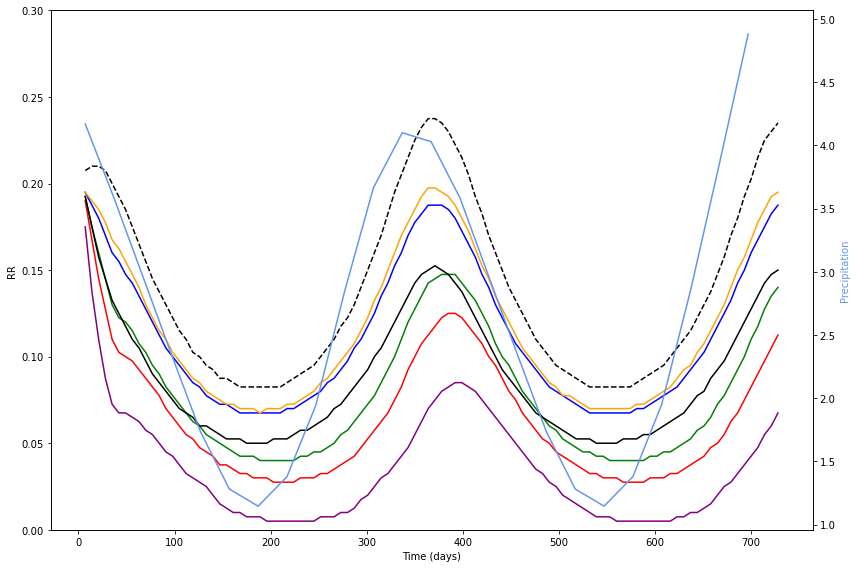

In [8]:
#ABSOLUTE VALUES

Bobo = np.genfromtxt(fname="Rio.txt") # import precipitation data
Bobo2 = sm.nonparametric.lowess(Bobo[:,1], Bobo[:,0], frac=0.8/3) # smooth the curve
Bobo3 = Bobo2[:,1] #cut down the middle for a nice year loop
week = range(7,365*2,7)
month_pre = Bobo2[:,0]
month = [7]
for i in month_pre[:23]:
    month.append((i*30)+7)

t1 = week #[200,250,300,350,400,450,500,550] #week # weekly time points
t2 = month #Bobo2[:,0]*30 #Bobo4*30 # monthly time points
data0 = Bobo3 # precipitation values
data_nosupp = nosupp_vec
data1 = RIDL_vec
data2 = SIT_vec
data3 = IIT_vec
data4 = EM_vec
data5 = LV_vec
data6 = AD_vec

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('RR')
ax1.set_ylim(0,0.3)
ax1.plot(t1, data_nosupp, color='black', linestyle = 'dashed')
ax1.plot(t1, data1, color='red') #RIDL
ax1.plot(t1, data2, color='green') #SIT
ax1.plot(t1, data3, color='purple') #IIT
ax1.plot(t1, data4, color='blue') #EM
ax1.plot(t1, data5, color='orange') #LV
ax1.plot(t1, data6, color='black') #AD

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Precipitation', color='cornflowerblue')
ax2.plot(t2, data0, color='cornflowerblue')

fig.tight_layout()
plt.show()

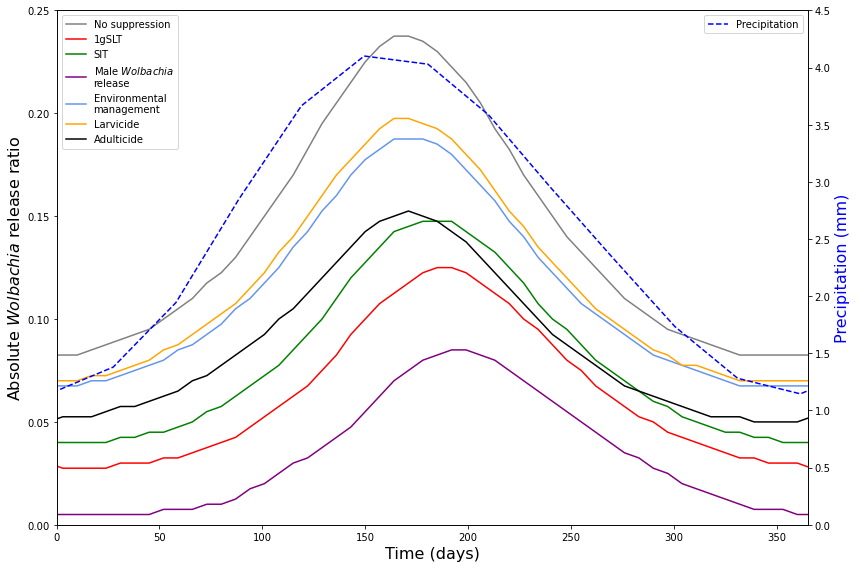

In [13]:
#ABSOLUTE VALUES - year slice down the middle

Bobo = np.genfromtxt(fname="Rio.txt") # import precipitation data
Bobo2 = sm.nonparametric.lowess(Bobo[:,1], Bobo[:,0], frac=0.8/3) # smooth the curve
Bobo3 = Bobo2[:,1] #cut down the middle for a nice year loop
week = range(7,365*2,7)
#month_pre = Bobo2[:,0]
#month = [7]
#for i in month_pre[:23]:
#    month.append((i*30)+7)
month = [15.5,29.5,74.5,105,135.5,166,196.5,227.5,258,288.5,319,349.5,
         380.5,410,439.5,470,500.5,531,561.5,592.5,623,653.5,684,714.5]

t1 = week #[200,250,300,350,400,450,500,550] #week # weekly time points
t2 = month #Bobo2[:,0]*30 #Bobo4*30 # monthly time points
data0 = Bobo3 # precipitation values
data_nosupp = nosupp_vec
data1 = RIDL_vec
data2 = SIT_vec
data3 = IIT_vec
data4 = EM_vec
data5 = LV_vec
data6 = AD_vec

fig, ax1 = plt.subplots(figsize=(12,8))
ax1.set_xlabel('Time (days)', size=16)
ax1.set_ylabel('Absolute $\it{Wolbachia}$ release ratio', size=16)
ax1.set_ylim(0, 0.3)
ax1.plot(t1, data_nosupp, color='grey', label="No suppression")
ax1.plot(t1, data1, color='red', label="1gSLT") #RIDL
ax1.plot(t1, data2, color='green', label="SIT") #SIT
ax1.plot(t1, data3, color='purple', label="Male $\it{Wolbachia}$\nrelease") #IIT
ax1.plot(t1, data4, color='cornflowerblue', label="Environmental\nmanagement") #EM
ax1.plot(t1, data5, color='orange', label="Larvicide") #LV
ax1.plot(t1, data6, color='black', label="Adulticide") #AD
ax1.set_xticks([200,250,300,350,400,450,500,550],[0,50,100,150,200,250,300,350])
ax1.set_xlim(200,565)
ax1.set_ylim(0,0.25)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Precipitation (mm)', color='blue', size=16)
ax2.set_ylim(0,4.5)
ax2.plot(t2, data0, color='blue', linestyle = 'dashed', label="Precipitation")

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

#plt.savefig('Figure6.jpeg', bbox_inches='tight', dpi = 600)

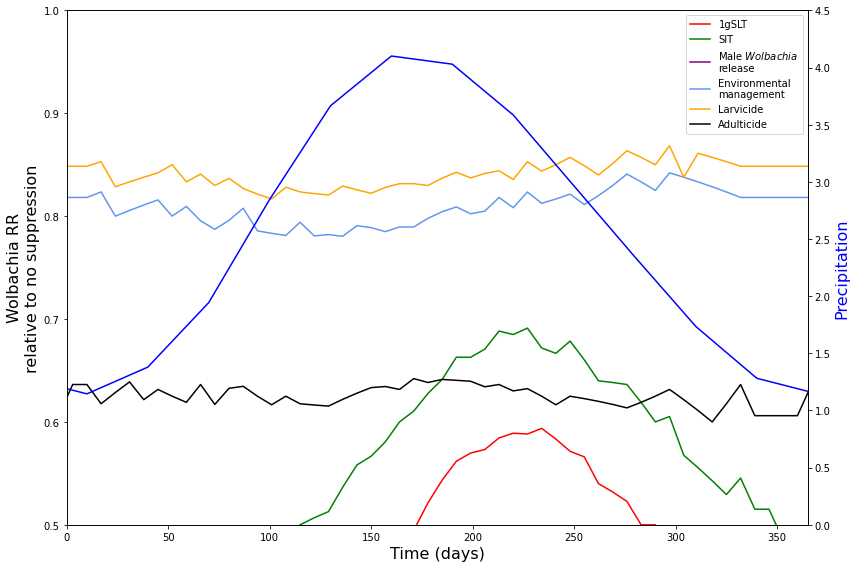

In [10]:
#NORMALISED - relative to no suppression

Bobo = np.genfromtxt(fname="Rio.txt") # import precipitation data
Bobo2 = sm.nonparametric.lowess(Bobo[:,1], Bobo[:,0], frac=0.8/3) # smooth the curve
Bobo3 = Bobo2[:,1]#[5:18] #cut down the middle for a nice year loop
#Bobo4 = Bobo2[:,0][0:12] #month numbers
#Bobo4 = np.insert(Bobo4, 0, 0)
#week = range(1,365,7)
#month = range(1,13)

week = range(7, 365*2,7)
#month_pre = Bobo2[:,0]
#month = [7]
#for i in month_pre[:23]:
#    month.append((i*30)+7)
month = [15.5,29.5,74.5,105,135.5,166,196.5,227.5,258,288.5,319,349.5,
         380.5,410,439.5,470,500.5,531,561.5,592.5,623,653.5,684,714.5]


t1 = week #[200,250,300,350,400,450,500,550] #week # weekly time points
t2 = Bobo2[:,0]*30 #Bobo4*30 # monthly time points
data0 = Bobo3 # precipitation values
data1 = RIDL_vec_norm
data2 = SIT_vec_norm
data3 = IIT_vec_norm
data4 = EM_vec_norm
data5 = LV_vec_norm
data6 = AD_vec_norm

fig, ax1 = plt.subplots(figsize = (12,8))
ax1.set_xlabel('Time (days)', size=16)
ax1.set_ylabel('Wolbachia RR\nrelative to no suppression', size=16)
ax1.set_ylim(0,1)
ax1.plot(t1, data1, color='red', label="1gSLT") #RIDL
ax1.plot(t1, data2, color='green', label="SIT") #SIT
ax1.plot(t1, data3, color='purple', label="Male $\it{Wolbachia}$\nrelease") #IIT
ax1.plot(t1, data4, color='cornflowerblue', label="Environmental\nmanagement") #EM
ax1.plot(t1, data5, color='orange', label="Larvicide") #LV
ax1.plot(t1, data6, color='black', label="Adulticide") #AD
ax1.set_xticks([200,250,300,350,400,450,500,550],[0,50,100,150,200,250,300,350])
ax1.set_xlim(200,565)
ax1.set_ylim(0.5,1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Precipitation', color='blue', size=16)
ax2.set_ylim(0,4.5)
ax2.plot(t2, data0, color='blue')

ax1.legend(loc='upper right')

fig.tight_layout()

### 2.d. Calculate result values

In [162]:
# % improvement of IIT RR compared to no suppression RR at optimal timing
100-((min(season_df.iloc[:,0])/min(season_df.iloc[:,3])))

83.5

In [163]:
# % improvement of no suppression RR from least to most optimal timing
(min(season_df.iloc[:,0])/max(season_df.iloc[:,0]))*100

34.73684210526316

In [164]:
# % improvement of no suppression RR at optimal timing compared to average timing
avg = (min(season_df.iloc[:,0])+max(season_df.iloc[:,0]))/2
(min(season_df.iloc[:,0])/avg)*100

51.5625